In [154]:
# import relevant libraries
!pip install pyspark
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
from functools import reduce

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics

%matplotlib inline

In [155]:
# create a Spark session
spark = SparkSession.builder.appName('SparkifyProj').getOrCreate()

In [156]:
# load gthe dataset
data = spark.read.json("/kaggle/input/spect-v1/mini_sparkify_event_data.json")

In [157]:
data.columns # list the column name

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [158]:
data.show(5) # display top 5 rows

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [159]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [160]:
data.count() # rows


286500

In [161]:
len(data.columns) # no of columns

18

In [162]:
# column wise NaN Values
print(f"{'Column Name':<20} {'Number of NaN':<20}")
print('--------------------------------------------')
for col in data.columns:
    n = data[(data[col].isNull()) | (data[col]=="")].count()
    
    print(f"{col:<20} {n:<20}")

Column Name          Number of NaN       
--------------------------------------------
artist               58392               
auth                 0                   
firstName            8346                
gender               8346                
itemInSession        0                   
lastName             8346                
length               58392               
level                0                   
location             8346                
method               0                   
page                 0                   
registration         8346                
sessionId            0                   
song                 58392               
status               0                   
ts                   0                   
userAgent            8346                
userId               8346                


In [163]:
# drop rows where user id is NaN
df_filtered = data.dropna(subset = ['userId'])

# filter the data to consider rows where userid is not empty
df_filtered = df_filtered.filter(df_filtered['userId'] != '')

In [164]:
# transform ts and registation time format
get_date_fn = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_filtered = df_filtered.withColumn('event_time', get_date_fn('ts'))
df_filtered = df_filtered.withColumn('registration_time', get_date_fn('registration'))

In [165]:
# get day number
get_day_fn = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_filtered = df_filtered.withColumn('day_of_month', get_day_fn('ts'))

In [166]:
# extract Operating System
dict_map = {'Compatible': 'Windows', 'Ipad': 'iPad', 'Iphone': 'iPhone', 'Macintosh': 'Mac',  
       'Windows nt 5.1': 'Windows', 'Windows nt 6.0': 'Windows', 'Windows nt 6.1': 'Windows', 
       'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows', 'X11': 'Linux'}

get_operating_sys = udf(lambda x: dict_map[re.findall('\(([^\)]*)\)', x)[0].split(';')[0].capitalize()])
df_filtered = df_filtered.withColumn('operating_system', get_operating_sys(df_filtered.userAgent))

In [167]:
# extract state from location
get_location_fn = udf(lambda x:x[-2:len(x)])
df_filtered = df_filtered.withColumn('location_state', get_location_fn(df_filtered.location))
df_filtered.select('location_state').distinct().show(5)

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            VA|
+--------------+
only showing top 5 rows



In [168]:
# create feature "downgrade"
downgrade_event_fn = udf(lambda x: 0 if x != 'Submit Downgrade' else 1, IntegerType())
df_filtered = df_filtered.withColumn('downgrade_event', downgrade_event_fn('page'))
df_filtered = df_filtered.withColumn('downgrade', max('downgrade_event').over(Window.partitionBy('userId')))

In [169]:
# create feature "churn"
churn_event = udf(lambda x: 0 if x != 'Cancellation Confirmation' else 1, IntegerType())
df_filtered = df_filtered.withColumn('churn_event', churn_event('page'))
df_filtered = df_filtered.withColumn('churn', max('churn_event').over(Window.partitionBy('userId')))

# EDA

In [202]:
df_pd = df_filtered.toPandas()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


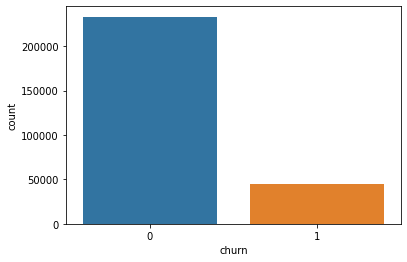

In [206]:
sns.countplot(df_pd['churn'])
plt.show()

In [217]:
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,userId,event_time,registration_time,day_of_month,operating_system,location_state,downgrade_event,downgrade,churn_event,churn
0,OneRepublic,Logged In,Bryanna,F,0,Stone,224.67873,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,100008,2018-10-09 16:14:24,2018-09-20 10:44:31,9,Mac,CA,0,1,0,0
1,Guns N' Roses,Logged In,Bryanna,F,1,Stone,182.36036,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,100008,2018-10-09 16:18:08,2018-09-20 10:44:31,9,Mac,CA,0,1,0,0
2,The Almost,Logged In,Bryanna,F,2,Stone,239.17669,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,100008,2018-10-09 16:21:10,2018-09-20 10:44:31,9,Mac,CA,0,1,0,0
3,Maroon 5,Logged In,Bryanna,F,3,Stone,231.23546,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,100008,2018-10-09 16:25:09,2018-09-20 10:44:31,9,Mac,CA,0,1,0,0
4,LMFAO,Logged In,Bryanna,F,4,Stone,225.64526,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,...,100008,2018-10-09 16:29:00,2018-09-20 10:44:31,9,Mac,CA,0,1,0,0


In [232]:
def statPlot(colname):
    
    ############# crarte df ################
    df1 = df_pd[[colname,'churn']]

    df1  = df1.groupby([colname, 
                              'churn']).size().reset_index().pivot(columns='churn', 
                                                                        index=colname, 
                                                                    values=0)
#     return df1
    df1['percentage_of_churn']= df1[1]*100/(df1[0]+ df1[1])
    # df_job['percentage_of_unsubscribers']= df_job['no']/(df_job['no']+ df_job['yes'])
    df1.dropna(inplace=True)
    df1= df1.sort_values('percentage_of_churn').reset_index()
    df1[colname] = df1[colname].astype('str')
    
    ##### PLOT ####################
    plt.figure(figsize=(15,5))
    ax = sns.barplot(df1[colname],df1['percentage_of_churn'],
                     palette="vlag")
    for bars in ax.containers:
        ax.bar_label(bars, fmt="%.2f%%")
    plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


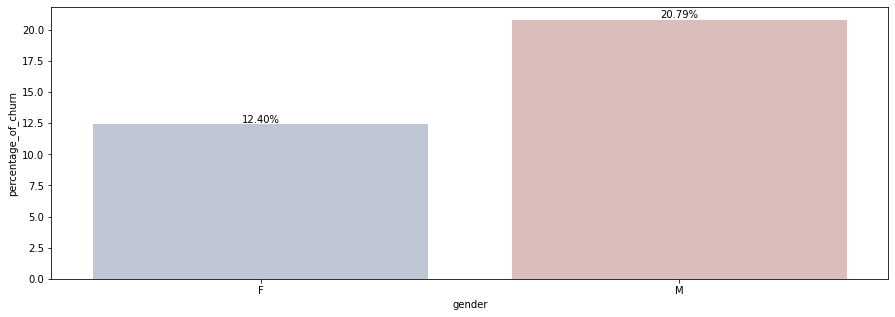

In [233]:
statPlot('gender')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


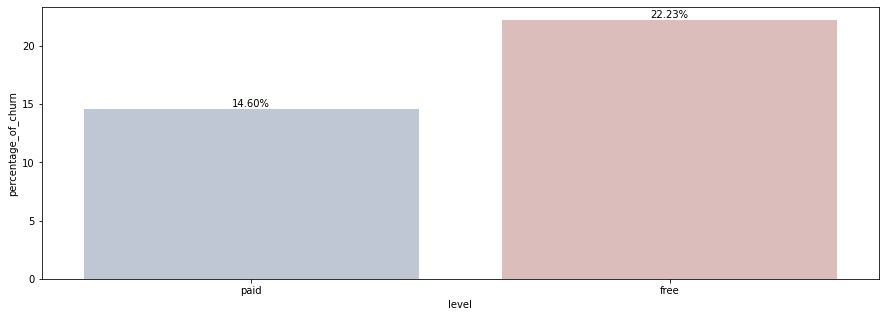

In [234]:
statPlot('level')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


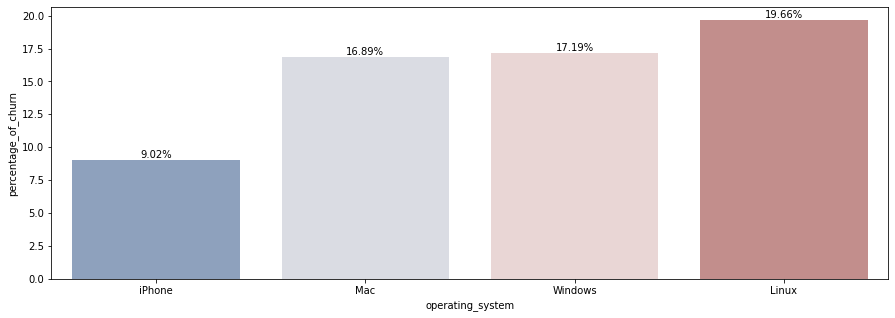

In [235]:
statPlot('operating_system')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


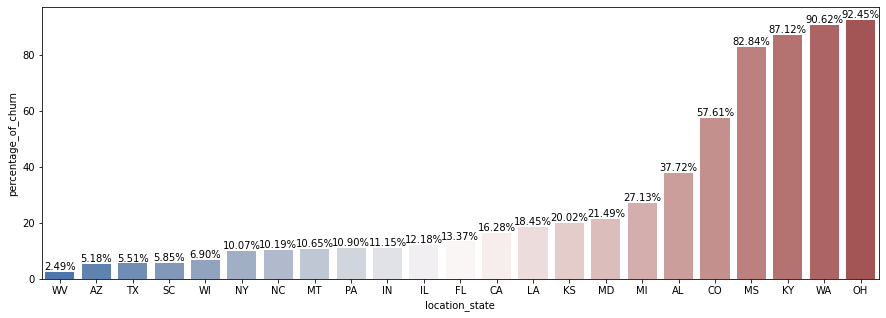

In [236]:
statPlot('location_state')

In [172]:
model_features = [] # store model features

In [173]:
# gender of the user
temp = df_filtered.select(['userId', 'gender']).dropDuplicates(['userId'])
temp = temp.replace(['F', 'M'], ['0', '1'], 'gender')
df_gender = temp.withColumn('gender', temp.gender.cast('int'))
model_features.append(df_gender)
df_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    10|     1|
|   100|     1|
|100001|     0|
|100002|     0|
|100003|     0|
+------+------+
only showing top 5 rows



In [174]:
# level of the user
temp = df_filtered.select(['userId', 'level']).dropDuplicates(['userId'])
temp = temp.replace(['paid', 'free'], ['0', '1'], 'level')
df_payment = temp.withColumn('level', temp.level.cast('int'))
model_features.append(df_payment)
df_payment.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [175]:
# did the user downgrade
temp = df_filtered.select(['userId','downgrade']).dropDuplicates(['userId']) 
df_downgrade = temp.withColumn('downgrade', temp.downgrade.cast('int'))
model_features.append(df_downgrade)
df_downgrade.show(5)

+------+---------+
|userId|downgrade|
+------+---------+
|    10|        0|
|   100|        1|
|100001|        0|
|100002|        0|
|100003|        0|
+------+---------+
only showing top 5 rows



In [176]:
# did the user churn
temp = df_filtered.select(['userId','churn']).dropDuplicates(['userId'])
df_churn = temp.withColumn('churn', temp.churn.cast('int'))
df_churn.show(5) 

+------+-----+
|userId|churn|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [177]:
# number of songs the user listened to in total
num_songs = df_filtered.select('userID','song').groupBy('userID').count()
model_features.append(num_songs)

In [178]:
# number of Thumbs-Up/Down
num_thumbs_up = df_filtered.select('userID','page').where(df_filtered.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_up') 
print(num_thumbs_up.show(5))
model_features.append(num_thumbs_up)
num_thumbs_down = df_filtered.select('userID','page').where(df_filtered.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'num_thumbs_down') 
model_features.append(num_thumbs_down)
print(num_thumbs_down.show(5)) 

+------+-------------+
|userID|num_thumbs_up|
+------+-------------+
|    51|          100|
|   124|          171|
|     7|            7|
|    54|          163|
|    15|           81|
+------+-------------+
only showing top 5 rows

None
+------+---------------+
|userID|num_thumbs_down|
+------+---------------+
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
+------+---------------+
only showing top 5 rows

None


In [179]:
# number of songs added to playlist
num_playlist = df_filtered.select('userID','page').where(df_filtered.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'num_playlist')
model_features.append(num_playlist)
num_playlist.show(5) 

+------+------------+
|userID|num_playlist|
+------+------------+
|    51|          52|
|   124|         118|
|    15|          59|
|    54|          72|
|   132|          38|
+------+------------+
only showing top 5 rows



In [180]:
# number of friends added
num_friends = df_filtered.select('userID','page').where(df_filtered.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'num_friend')
model_features.append(num_friends)
num_friends.show(5)

+------+----------+
|userID|num_friend|
+------+----------+
|    51|        28|
|   124|        74|
|     7|         1|
|    54|        33|
|    15|        31|
+------+----------+
only showing top 5 rows



In [181]:
# total length of listening
sum_listened = df_filtered.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'sum_listened')
model_features.append(sum_listened)
sum_listened.show(5) 

+------+------------------+
|userID|      sum_listened|
+------+------------------+
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
|     7|        38034.0871|
|    54| 711344.9195399994|
+------+------------------+
only showing top 5 rows



In [182]:
# Number of songs listened per session
av_song_session = df_filtered.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'av_song_session')
model_features.append(av_song_session)
av_song_session.show(5)

+------+------------------+
|userId|   av_song_session|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [183]:
# number of artists listened to
num_artists = df_filtered.filter(df_filtered.page=="NextSong").select(['userId', 'artist']).dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_artists') 
model_features.append(num_artists)
num_artists.show(5) 

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



In [184]:
# time since registration in days
days_member = df_filtered.select('userId','ts','registration').withColumn(
    'days_member',((df_filtered.ts - df_filtered.registration)/1000/3600/24)).groupBy('userId').agg(
    {'days_member':'max'}).withColumnRenamed('max(days_member)','days_member') 

model_features.append(days_member)
days_member.show(5) 

+------+------------------+
|userId|       days_member|
+------+------------------+
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
+------+------------------+
only showing top 5 rows



In [185]:
# session count per user
num_session = df_filtered.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions') 
model_features.append(num_session)
num_session.show(5) 

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [186]:
# duration of the session
sessionStart = df_filtered.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
sessionEnd = df_filtered.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
durSession = sessionStart.join(sessionEnd, ['userId', 'sessionId'])
durSession = durSession.select('userId', 'sessionId', ((durSession.end-durSession.start)/(1000*60*60)).alias('dur_session'))
model_features.append(durSession)
durSession.show(5)

+------+---------+-------------------+
|userId|sessionId|        dur_session|
+------+---------+-------------------+
|    92|      358|  4.288611111111111|
|    42|      433| 1.2455555555555555|
|   101|      635| 55.000277777777775|
|   120|      627| 15.855555555555556|
|   140|      798|0.16027777777777777|
+------+---------+-------------------+
only showing top 5 rows



In [187]:
for i, feature_to_join in enumerate(model_features):
    df_churn = df_churn.join(feature_to_join,'userID','outer')

In [188]:
df_churn = df_churn.drop('userID') 
df_final = df_churn.na.fill(0)

In [189]:
print((df_final.count(), len(df_final.columns)))

(3176, 16)


In [190]:
# rename
df_final = df_final.withColumnRenamed("churn","label")

In [191]:
# vector assembler
assembler = VectorAssembler(inputCols=df_final.columns[1:], outputCol="features")
data = assembler.transform(df_final)
data

DataFrame[label: int, gender: int, level: int, downgrade: int, count: bigint, num_thumbs_up: bigint, num_thumbs_down: bigint, num_playlist: bigint, num_friend: bigint, sum_listened: double, av_song_session: double, num_artists: bigint, days_member: double, num_sessions: bigint, sessionId: bigint, dur_session: double, features: vector]

In [192]:
# standard scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [193]:
# drop column "features" - as no longer needed
data = data.drop("features")

In [194]:
# split the data into train and test 
train, test = data.randomSplit([0.8, 0.2], seed=42)

In [195]:
from sklearn.metrics import classification_report,accuracy_score
def get_report(model):
    p_df = model.toPandas()
    y_true = p_df['label']
    y_pred = p_df['prediction']
    print(classification_report(y_true,y_pred))
    acc = accuracy_score(y_true,y_pred)
    return acc

# LogisticRegression

In [196]:
lr =  LogisticRegression(featuresCol='scaled_features', labelCol='label')
lr_clf = lr.fit(train)
lr_acc = get_report(lr_clf.transform(test))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92       477
           1       0.69      0.37      0.48       107

    accuracy                           0.85       584
   macro avg       0.78      0.67      0.70       584
weighted avg       0.84      0.85      0.84       584



# DecisionTreeClassifier

In [197]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")
dt_clf = dt.fit(train)
dt_acc = get_report(dt_clf.transform(test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       477
           1       0.92      0.79      0.85       107

    accuracy                           0.95       584
   macro avg       0.94      0.89      0.91       584
weighted avg       0.95      0.95      0.95       584



# RandomForestClassifier

In [198]:
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")
rf_clf = rf.fit(train)
rf_acc = get_report(rf_clf.transform(test))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       477
           1       1.00      0.71      0.83       107

    accuracy                           0.95       584
   macro avg       0.97      0.86      0.90       584
weighted avg       0.95      0.95      0.94       584



# GBTClassifier

In [199]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features")
gbt_model = gbt.fit(train)
results_gbt = gbt_model.transform(test)

gbt_acc = get_report(results_gbt)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       477
           1       0.99      0.94      0.97       107

    accuracy                           0.99       584
   macro avg       0.99      0.97      0.98       584
weighted avg       0.99      0.99      0.99       584



# Comparison

In [200]:
results = pd.DataFrame({
    'Model': ['Logistic Regression','Decision Tree','Random Forest', 'Gradient Boost Tree'],
    'Score': [lr_acc,
                dt_acc,
                rf_acc,
                gbt_acc]})

result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score
Model,
Gradient Boost Tree,0.988014
Decision Tree,0.948630
Random Forest,0.946918
Logistic Regression,0.854452
